In [35]:
### Import Libraries ###

# Pandas for managing datasets
import pandas as pd

# Matplotlib for additional customization
from matplotlib import pyplot as plt
%matplotlib inline

# Seaborn for plotting and styling
import seaborn as sns

# Numpy, Statistics and Random for math
import numpy as np
import random as rand
import statistics
import scipy.signal

# Warnings to remove complex to real conversion warnings
import warnings
warnings.filterwarnings('ignore')

# Scikit Learn for Machine Learning
import sklearn
from sklearn import metrics 
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

# SoundFile to for opening raw audio files
import soundfile as sf

In [24]:
### Define Functions ###

# Function to load a raw audio file and return all of the audio channels averaged together
def getAudioData(filename):
    # Load Raw Audio Data into [sig] and [sr]
    sig, sr = sf.read(filename+'.raw', channels=2, samplerate=62500, format='RAW', subtype='PCM_16')

    # Define an empty array to store the combined audio channels
    data = []

    # Average the left and right audio channels and store in [data]
    for i in range(0, len(sig)):
        average = (sig[i][0]+sig[i][1])/2
        data.append(average)
    return data

# Function to clean a pandas dataset
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

# Function to get the shape of an object
def returnShape(*args):
    return np.broadcast(*args).shape

# Function to calculate the label for a window
def calculateLabel(labels):
    total = sum(labels)
    num = len(labels)
    if total/num > 0.4:
        return 1
    else:
        return 0

# Function to split a Pandas DataFrame into equal size parts based on [chunkSize]
def splitDataFrameIntoSmaller(df, chunkSize = 10000): 
    listOfDf = list()
    numberChunks = len(df) // chunkSize + 1
    for i in range(numberChunks):
        listOfDf.append(df[i*chunkSize:(i+1)*chunkSize])
    return listOfDf

# Function to convert a complex number to a real number
def convertToReal(c):
    return (c.real**2)+(c.imag**2)

# Function to calculate the mean value of an array
def mean(array):
    return np.mean(array, dtype=np.float64)

# Function to calculate the median value of an array
def median(array):
    return np.median(array)

# Function to calculate the mean value of the FFT of an array
def meanFFT(array):
    fft = np.fft.fft(array)
    return convertToReal(mean(fft))

# Function to calculate the median value of the FFT of an array
def medianFFT(array):
    fft = np.fft.fft(array)
    return convertToReal(median(fft))

# Function to calculate the maximum value of the FFT of an array
def maxFFT(array):
    fft = np.fft.fft(array)
    return convertToReal(max(fft))

# Function to calculate the minimum value of the FFT of an array
def minFFT(array):
    fft = np.fft.fft(array)
    return convertToReal(min(fft))

# Function to calculate the sum of the FFT of an array
def sumFFT(array):
    fft = np.fft.fft(array)
    return convertToReal(sum(fft))

# Function to calculate the standard deviation of the FFT of an array
def stdevFFT(array):
    fft = np.fft.fft(array)
    return statistics.stdev(list(map(convertToReal, fft)))

def winSizeToSeconds(winSize, sampling_rate):
    winSize = float(winSize)
    sampling_rate = float(sampling_rate)
    one = 1/sampling_rate
    return one*winSize

def runningAverage(avg, new_sample, N):
    avg -= avg / N
    avg += new_sample / N

    return avg

In [3]:
### Generate Window Sizes ###

windowSizes = list(np.arange(300, 9001, 300))
print(windowSizes)

[300, 600, 900, 1200, 1500, 1800, 2100, 2400, 2700, 3000, 3300, 3600, 3900, 4200, 4500, 4800, 5100, 5400, 5700, 6000, 6300, 6600, 6900, 7200, 7500, 7800, 8100, 8400, 8700, 9000]


In [13]:
### Open the Raw Audio Files, Convert them to .csv Files and Label them ###

# Open the .csv that information about the audio files # signed 8 bit pcm 62500 hz
data_loc = pd.read_csv('DataLoc.csv').values

# Define an empty array [audio_data] to store the data from the raw audio files
audio_data = []

# Loop through all of the lines in [data_loc] (One for each file)
for i in range(0, len(data_loc)):
    # Store the audio data in [audio_sig]
    audio_sig = getAudioData(data_loc[i][2])
    
    # Generate arrays of ones and zeroes equal to length of speaking and not speaking
    starting_silence = [0]*data_loc[i][0]
    speaking = [1]*(data_loc[i][1]-data_loc[i][0])
    ending_silence = [0]*(len(audio_sig) - data_loc[i][1])
    
    # Combine the arrays into one larger array
    labels = starting_silence+speaking+ending_silence
    
    # Append the [audio_sig] and [labels] to [audio_data]
    audio_data.append([audio_sig, labels])
    
# Loop through each item in [audio_data]
for i in range(0, len(audio_data)):
    
    # Save each line of the file into a .csv file
    with open(str(i)+'.csv', 'a+') as csv:
        csv.seek(0)
        csv.truncate()
        
        # Write the header
        csv.write('sig,label,fileID\n')
        
        # Loop through each line and write the signal and label
        for j in range(0, len(audio_data[i][0])):
            ## print(returnShape(audio_data[i]))
            sig = str(audio_data[i][0][j])
            label = str(audio_data[i][1][j])
            csv.write(sig+','+label+','+str(i)+'\n')

In [4]:
## Load the Labeled .csv Files into [windows] ###
windows = []
for i in range(0, 8):
    windows.append(pd.read_csv(str(i)+'.csv'))

In [15]:
### Calculate the Features for each Window Size ###

# Define an empty array to store the features
features = []

## Loop through all of the window sizes and data, calculate the feater and append it to features ##

# Loop through [windows] (An array storing each of the .csv files)
for i in range(0, len(windows)):
    # Loop through all of the [windowSizes]
    for j in range(0, len(windowSizes)):
        # Split [windows{i}] into parts based on the current [windowSize]
        data = splitDataFrameIntoSmaller(windows[i], windowSizes[j])
        # Loop through every line in data
        for k in range(0, len(data)-1):
            # Store the current windowSize, audio signal, label, and fileID
            windowSize = float(windowSizes[j])
            sig = list(map(float, data[k]['sig']))
            label = calculateLabel(data[k]['label'].values)
            ID = median(data[k]['fileID'].values)
            ## print(ID)
            
            # Append the fileID, windowSize, all of the features, and label to [features]
            features.append([ID, windowSize, mean(sig), median(sig), min(sig), 
                                        max(sig), sum(sig), statistics.stdev(sig), meanFFT(sig), 
                                        medianFFT(sig), minFFT(sig), maxFFT(sig), sumFFT(sig), stdevFFT(sig), label])
# Convert [features] to a DataFrame and store it in [dataFrame]
dataFrame = pd.DataFrame(data=features)
# Set [dataFrame]'s columns
dataFrame.columns = ['fileID','windowSize','mean','median','min','max','sum','stdev','meanFFT','medianFFT','minFFT','maxFFT','sumFFT','stdevFFT','label']
# Save [dataFrame] as "Windows.csv"
dataFrame.to_csv('Windows.csv', sep=',', index=False)

In [5]:
### Pick a random file to always train on and define an array storing all of the files ###
file_num = [0, 1, 2, 3, 4, 5, 6, 7]
items = rand.sample(file_num, 1)
print(items)

[2]


In [7]:
### Train and Test the data on each Window Size ###
data = pd.read_csv('Windows.csv')
data = clean_dataset(data)
## print data.head()
dataColumns = ['mean','median','min','max','sum','stdev','meanFFT','medianFFT','minFFT','maxFFT','sumFFT','stdevFFT']

print('### Confusion Matrix for each Window Size ###')
print('        (Window Sizes are in seconds)')

# Define empty arrays to store the machine learning result 
matrix = []
chart = []
zero_r_y = []
one_r_y = []
one_r_features = []

# Define int to store the sampling rate
sampling_rate = 62500

# Loop through all window Sizes
for i in range(0, len(windowSizes)):
    ## print('i')
    ## print(i)
    # Define variables to store the mean accuracy, and the current window size
    mean_acc = []
    windowSize = windowSizes[i]
    mean_one_r = []
    
    # Loop through all of the randomly chosen files
    for j in range(0, len(file_num)):
        # Define vairable to store the 2 query strings and store the confusion matrix
        string = '('
        string2 = '('
        
        conf_matrix = [0]*4
        
        # Loop through all of the randomly chosen files and update the query strings
        for k in range(0, len(file_num)):
            if  (file_num[k]  in items) or k == j:
                string2 += 'fileID=='+str(file_num[k])+' or '
            else:
                string += 'fileID=='+str(file_num[k])+' or '
        
        # Finish editing the query strings
        string = string[:-3] + ') and windowSize=='+str(windowSize)
        string2 = string2[:-3]+') and windowSize=='+str(windowSize)
        
        #print(string)
        #print(string2)
        
        # Use the query strings to genereate train and test, data and values
        trainDataValues = data.query(string).filter(items=dataColumns)
        trainLabels = data.query(string).filter(items=['label'])
        testDataValues = data.query(string2).filter(items=dataColumns)
        testLabels = data.query(string2).filter(items=['label'])
        
        # Initilize Classifiers
        ## mnb = GaussianNB()
        mnb = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=0)
        
        # Train and predict the model
        mnb.fit(trainDataValues, trainLabels)
        predicted = mnb.predict(testDataValues)
        
        # Store the accuracy in [fold], [mean] and [matrix]
        fold = metrics.accuracy_score(testLabels,predicted)
        mean_acc.append(fold)
        matrix.append([windowSize,fold,file_num[j]])
        
        # Store the confusion matrix in [conf_matrix]
        conf_matrix = np.add(conf_matrix, metrics.confusion_matrix(testLabels, predicted).ravel())
        
        ## Calculate Zero R ##
        best_clf = None
        best_accuracy = 0
        best_feature = 0
        for i in range(0, len(dataColumns)):
            feature = i
            clf = tree.DecisionTreeClassifier(max_depth=1)
            clf.fit(trainDataValues.filter(items=[dataColumns[feature]]), trainLabels)
            predicted = clf.predict(testDataValues.filter(items=[dataColumns[feature]]))
            accuracy = metrics.accuracy_score(testLabels,predicted)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_clf = clf   
                best_feature = feature
        one_r_features.append(feature)
        mean_one_r.append(accuracy)
    
    # Print the averaged confusion matrix from the inner loop
    windowSizeSec = winSizeToSeconds(windowSize, sampling_rate)
    print('Window Size '+str(windowSizeSec)+': '+str(map(float, np.divide(conf_matrix, float(len(file_num))))))
    
    # Append the [windowSize] and mean accuracy to chart
    chart.append([windowSize,np.mean(mean_acc)])
    
    ## Calcuate Zero R ##
    
    # Store the number of windows for the current iterations in [length]
    length = data.query('windowSize == '+str(windowSize)).shape[0]
    # Store the number of windows (Of the current [windowSize]) for which there was no talking in [not_talking]
    not_talking = data.query('windowSize == '+str(windowSize)+' and label == 0').shape[0]
    # Store the Zero R accuracy in [acc]
    acc = float(not_talking)/length
    # Append [acc] to [zero_r_y]
    zero_r_y.append(acc)
    
    one_r_y.append(np.mean(mean_one_r))
    
# Convert [matrix] to a DataFrame
matrix = pd.DataFrame(matrix, columns=['windowSize','accuracy','fileID'])
# Save [matrix] as a .csv
matrix.to_csv('windowResults.csv', sep=',', index=False)

# Convert [chart] to a DataFrame
chart = pd.DataFrame(chart, columns=['windowSize','accuracy'])

### Confusion Matrix for each Window Size ###
        (Window Sizes are in seconds)
Window Size 0.0048: [94.375, 0.75, 3.75, 12.75]
Window Size 0.0096: [47.25, 0.375, 2.75, 5.375]
Window Size 0.0144: [31.625, 0.125, 2.0, 3.375]
Window Size 0.0192: [23.875, 0.0, 1.25, 2.625]
Window Size 0.024: [19.0, 0.125, 0.875, 2.25]
Window Size 0.0288: [15.875, 0.125, 0.75, 1.75]
Window Size 0.0336: [13.5, 0.125, 0.75, 1.5]
Window Size 0.0384: [11.875, 0.125, 0.625, 1.25]
Window Size 0.0432: [10.625, 0.0, 0.5, 1.125]
Window Size 0.048: [9.625, 0.125, 0.375, 1.0]
Window Size 0.0528: [8.625, 0.125, 0.25, 1.0]
Window Size 0.0576: [7.75, 0.125, 0.375, 0.875]
Window Size 0.0624: [7.25, 0.125, 0.375, 0.625]
Window Size 0.0672: [6.875, 0.0, 0.5, 0.5]
Window Size 0.072: [6.25, 0.25, 0.125, 0.625]
Window Size 0.0768: [5.75, 0.25, 0.625, 0.25]
Window Size 0.0816: [5.75, 0.0, 0.375, 0.25]
Window Size 0.0864: [5.375, 0.0, 0.5, 0.25]
Window Size 0.0912: [5.0, 0.125, 0.125, 0.5]
Window Size 0.096: [4.625, 0.25, 0

Best Accuracy:
0.9865229885057472

Most Influential Feature (One R):
stdevFFT


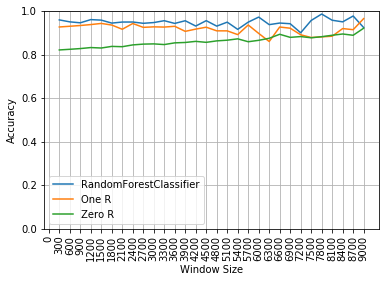

In [8]:
y = chart['accuracy']
x = chart['windowSize']

rfc = plt.plot(x, y, label='RandomForestClassifier')
one_r = plt.plot(x, one_r_y, label='One R')
zero_r = plt.plot(x, zero_r_y, label='Zero R')

label_location = [0]+windowSizes
plt.xticks(label_location, rotation='vertical')
plt.grid()
plt.ylim(0, 1)
plt.xlabel('Window Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print('Best Accuracy:')
print(max(chart['accuracy'].values))
print('\nMost Influential Feature (One R):')
print(dataColumns[int(np.median(one_r_features))])

In [22]:
### Real-Time Detection ###

# Import libraries
from __future__ import print_function
import pyaudio
import sys
import time

# Define global vairables
FORMAT = pyaudio.paInt8
CHANNELS = 1
RATE = 62500
WIN_SIZE = 300

# Create a PyAudio Object
audio = pyaudio.PyAudio()

# Get the microphone
stream = audio.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=RATE, 
                    input=True,
                    frames_per_buffer=WIN_SIZE)

# Open the calculated features and clean the dataset
test = pd.read_csv('Windows.csv')
test = clean_dataset(test)

# Filter out uneeded columns and only keep a windowSize of 300
dataColumns = ['mean','median','min','max','sum','stdev','meanFFT','medianFFT','minFFT','maxFFT','sumFFT','stdevFFT']
trainDataValues = test.query('windowSize=='+str(WIN_SIZE)).filter(items=dataColumns)
trainLabels = test.query('windowSize=='+str(WIN_SIZE)).filter(items=['label'])
print('Got Data')

# Create and Train a RandomForestClassifier
mnb = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=0)
mnb.fit(trainDataValues, trainLabels)
print('Trained Model')

## # Get data from the microphone
## sig = np.fromstring(stream.read(CHUNK, exception_on_overflow = False), np.int16)
## print mnb.predict([[mean(sig),median(sig),min(sig),max(sig),sum(sig),statistics.stdev(sig),meanFFT(sig),medianFFT(sig),minFFT(sig),maxFFT(sig),sumFFT(sig),stdevFFT(sig)]])

avg = 0

while True:
    try:
        # Get Data From the microphone
        sig = np.fromstring(stream.read(WIN_SIZE, exception_on_overflow=False), np.int16)
        sig = np.divide(sig, 85)
        ## print(sig)
        
        # Calulate all of the features over that data
        features = [mean(sig),median(sig),min(sig),max(sig),sum(sig),statistics.stdev(sig),
                    meanFFT(sig),medianFFT(sig),minFFT(sig),maxFFT(sig),sumFFT(sig),stdevFFT(sig)]
        
        # Make a detection based on those features
        prediction = mnb.predict([features])
        
        # Overwrite the previous print out with the new detection
        print(prediction, end='\r')
        sys.stdout.flush()
        
        # If the prediction was one, sleep for a bit
        #if prediction == 1:
        #    time.sleep(0.1)
            
    # If there is a ~KeyboardInterrupt~ close all of the audio objects
    except KeyboardInterrupt:
        stream.stop_stream()
        stream.close()
        audio.terminate()
        print('Closed Audio')

Got Data
Trained Model
Closed Audio


IOError: [Errno -9988] Stream closed

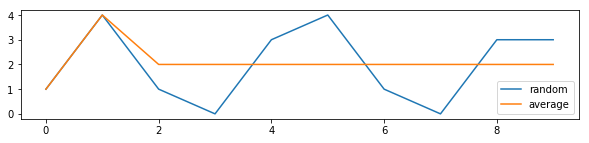

In [58]:
import random

num_samples = 10

N = 1
y = [1]
y2 = [y[0]]
x = np.arange(0, num_samples)
for i in range(0, num_samples-1):
    new_sample = random.randint(0, 4)
    y2.append(new_sample)
    new_avg = runningAverage(y[i], new_sample, N)
    y.append(new_avg)
    N += 1

#print(y)
#print(y2)

plt.figure(figsize=(10,2))
plt.plot(x, y2, label='random')
plt.plot(x, y, label='average')
plt.legend()
plt.show()